In [15]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"    

In [16]:
import importlib
import modules
import pandas as pd 
import cellpylib as cpl
import numpy as np 
import matplotlib.pyplot as plt
from modules import find_jams
from modules import triangulize_evolution
from modules import initial_to_random_walk
import scipy.optimize as opt
from modules import run_model
from modules import run_model_stochastic
from modules import calculate_flow_nasch
from modules import calculate_delay_nasch

import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import pandas as pd 


importlib.reload(modules)

<module 'modules' from 'C:\\Users\\李凌峰\\complex simulation system\\final version of NaSch\\modules.py'>

##  Total Delay and Average Delay 

In [17]:
import sys
sys.setrecursionlimit(5000000) 

Critical density: 0.2448979591836735


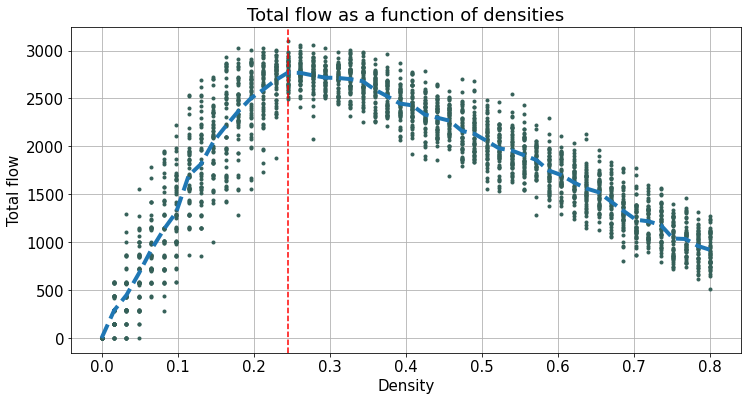

In [5]:
importlib.reload(modules)
import sys
from modules import run_model_stochastic
from modules import calculate_flow_nasch
sys.setrecursionlimit(5000000)
p = np.linspace(0, 0.8, 50)   
L = 100  
T = int(L / 2)
n = 50
p_slowdown = 0.1  
v_max = 3

total_flows_per_density = dict()
average_flows_per_density = dict()

for density in p:
    lifespan_counter, jam_size_counter, evolutions = run_model_stochastic(density, L, T, n, v_max=v_max, p_slowdown = p_slowdown, return_evolutions=True)
    

    total_flows = [calculate_flow_nasch(evolution) for evolution in evolutions]
    average_flows = [flow / float(T) for flow in total_flows]
    
    total_flows_per_density[density] = total_flows
    average_flows_per_density[density] = average_flows

# Find critical point: the density for which the total flow average is maximum
mean_total_flow_per_density = {density: np.mean(flows) for density, flows in total_flows_per_density.items()}
critical_density = max(mean_total_flow_per_density, key=mean_total_flow_per_density.get)
print(f"Critical density: {critical_density}")

# plot total flow as a function of densities
plt.figure(figsize=(12,6))
plt.title(f'Total flow as a function of densities',fontsize=18)
plt.plot(total_flows_per_density.keys(), total_flows_per_density.values(), 'o',markerfacecolor='#356058', markeredgecolor='#356058',markersize=3)
plt.plot(total_flows_per_density.keys(), [np.mean(flows) for flows in total_flows_per_density.values()], '--',linewidth=4) 

# Add a vertical line at the critical density
plt.axvline(x=critical_density, color='red', linestyle='--')
plt.grid(True)
plt.xlabel('Density',fontsize=15)
plt.ylabel('Total flow',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()





based on the v=3, pslow=0.3; check the critical density at 0.4 and its critical jamsize distribution

Critical density: 0.27755102040816326


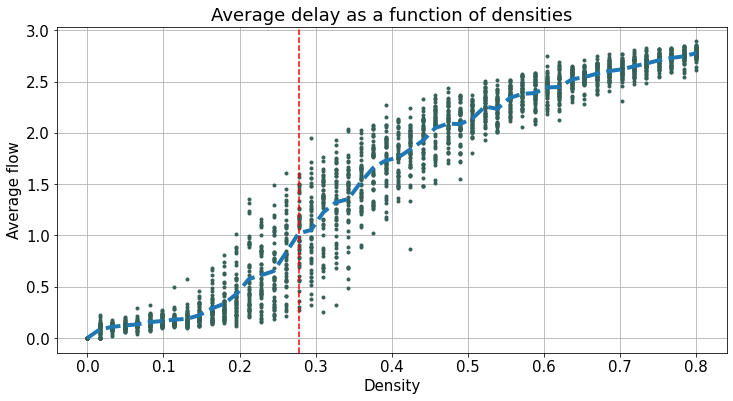

In [4]:
importlib.reload(modules)
import sys
from modules import run_model_stochastic
from modules import  calculate_delay_nasch
sys.setrecursionlimit(5000000)

p = np.linspace(0, 0.8, 50)    
L = 100
T = int(L / 2)
n = 50 
p_slowdown = 0.1 
v_max = 3

total_delays_per_density = dict() 
average_delays_per_density = dict()  

for density in p:
    lifespan_counter, jam_size_counter, evolutions = run_model_stochastic(density, L, T, n, v_max=v_max, p_slowdown = p_slowdown, return_evolutions=True)
    

    total_delays = [calculate_delay_nasch(evolution,v_max) for evolution in evolutions] 
    average_delays = [delay / float(T) for delay in total_delays]   
    
    total_delays_per_density[density] = total_delays  # n个evolution下的total delay 
    average_delays_per_density[density] = average_delays

# Find critical point: the density for which the total flow average is maximum
mean_total_delays_per_density = {density: np.mean(delays) for density, delays in total_delays_per_density.items()} 
df = pd.DataFrame(list(mean_total_delays_per_density.items()), columns=['Density', 'Average_Delay'])
df = df.sort_values(by='Density') #sort the data via density 
df['Delay_Difference'] = df['Average_Delay'].diff()
max_diff_index = df['Delay_Difference'].abs().idxmax()
max_diff_row = df.iloc[max_diff_index]
#max_diff_row["Density"]
critical_density= max_diff_row["Density"] 
# critical_density = min(mean_total_delays_per_density, key=mean_total_delays_per_density.get)   
print(f"Critical density: {critical_density}")

# plot total flow as a function of densities
plt.figure(figsize=(12,6))
plt.title(f'Average delay as a function of densities',fontsize=18) 
plt.plot(total_delays_per_density.keys(), total_delays_per_density.values(), 'o', markerfacecolor='#356058', markeredgecolor='#356058',markersize=3) 
plt.plot(total_delays_per_density.keys(), [np.mean(delays) for delays in total_delays_per_density.values()], '--',linewidth=4 ) 
# Add a vertical line at the critical density
plt.axvline(x=critical_density, color='red', linestyle='--')
plt.grid(True)
plt.xlabel('Density',fontsize=15)
plt.ylabel('Average delay',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()


# Confidence Interval part 

#### critical density dataset 
the dataset is from our github: critical_densities_nasch_n=10_L=200_T=100_#p=30_reps=10.csv

In [ ]:
df=pd.read_csv("E:\\UvA 课程\\complex simulation\\Project complex system\\CSS code\\critical_densities_nasch_n=10_L=200_T=100_#p=30_reps=10.csv")

df 

#### data pre-processing 

In [ ]:
df['critical_density'] = df['critical_density'].str.replace('[', '').str.replace(']', '')
expanded_cols = df['critical_density'].str.split(',', expand=True) #split the data 
expanded_cols = expanded_cols.apply(pd.to_numeric) # change to numerical form 
num_cols = expanded_cols.shape[1]  #obtain the critical density after spliting 
column_names = ['cd_{}'.format(i) for i in range(1, num_cols + 1)]
expanded_cols.columns = column_names
df = pd.concat([df, expanded_cols], axis=1) # concat the dataframes 
df.drop('critical_density', axis=1, inplace=True)
df['cd_mean'] = df.filter(like='cd_').mean(axis=1)
df['cd_std'] = df.filter(like='cd_').std(axis=1)


####  generate the 95% CI based on certain v_max

max speed =1 

In [ ]:
df_speed_1=df[df["v_max"]==1]
df_speed_1 
df_speed_1['lower'] = df_speed_1['cd_mean'] - 1.96 * df_speed_1['cd_std']
df_speed_1['upper'] = df_speed_1['cd_mean'] + 1.96 * df_speed_1['cd_std']

# Plot the data
plt.figure(figsize=(10, 5))
plt.fill_between(df_speed_1['p_slowdown'], df_speed_1['lower'], df_speed_1['upper'], color='#356058', alpha=0.3)
plt.plot(df_speed_1['p_slowdown'], df_speed_1['cd_mean'], color='black')
plt.xlabel('p_slowdown', fontsize=16)
plt.ylabel('Critical Density', fontsize=16)
plt.title('95% Confidence Interval of critical density in V_MAX=1', fontsize=17) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.ylim(0.1,0.6) 
plt.show()

max speed =2

In [74]:
df_speed_2=df[df["v_max"]==2]
df_speed_2 
df_speed_2['lower'] = df_speed_2['cd_mean'] - 1.96 * df_speed_2['cd_std']
df_speed_2['upper'] = df_speed_2['cd_mean'] + 1.96 * df_speed_2['cd_std']
# Plot the data
plt.figure(figsize=(10, 5))
plt.fill_between(df_speed_2['p_slowdown'], df_speed_2['lower'], df_speed_2['upper'], color='#356058', alpha=0.3)
plt.plot(df_speed_2['p_slowdown'], df_speed_2['cd_mean'], color='black')
plt.xlabel('p_slowdown', fontsize=16)
plt.ylabel('Critical Density', fontsize=16)
plt.title('95% Confidence Interval of critical density in V_MAX=2', fontsize=17) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.ylim(0.1,0.6)  
plt.show()

max speed=3 

In [74]:
df_speed_3=df[df["v_max"]==3]
df_speed_3 
df_speed_3['lower'] = df_speed_3['cd_mean'] - 1.96 * df_speed_3['cd_std']
df_speed_3['upper'] = df_speed_3['cd_mean'] + 1.96 * df_speed_3['cd_std']

# Plot the data
plt.figure(figsize=(10, 5))
plt.fill_between(df_speed_3['p_slowdown'], df_speed_3['lower'], df_speed_3['upper'], color='#356058', alpha=0.3)
plt.plot(df_speed_3['p_slowdown'], df_speed_3['cd_mean'], color='black')
plt.xlabel('p_slowdown', fontsize=16)
plt.ylabel('Critical Density', fontsize=16)
plt.title('95% Confidence Interval of critical density in V_MAX=3', fontsize=17)  
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.ylim(0.1,0.6)
plt.show()

max speed=4 

In [ ]:
df_speed_4=df[df["v_max"]==4]
df_speed_4 
df_speed_4['lower'] = df_speed_4['cd_mean'] - 1.96 * df_speed_4['cd_std']
df_speed_4['upper'] = df_speed_4['cd_mean'] + 1.96 * df_speed_4['cd_std']

# Plot the data
plt.figure(figsize=(10, 5))
plt.fill_between(df_speed_4['p_slowdown'], df_speed_4['lower'], df_speed_4['upper'], color='#356058', alpha=0.3)
plt.plot(df_speed_4['p_slowdown'], df_speed_4['cd_mean'], color='black')
plt.xlabel('p_slowdown', fontsize=16)
plt.ylabel('Critical Density', fontsize=16)
plt.title('95% Confidence Interval of critical density in V_MAX=4', fontsize=17) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.ylim(0.1,0.6)
plt.show()


max speed = 5 

In [ ]:
df_speed_5=df[df["v_max"]==5]
df_speed_5 
df_speed_5['lower'] = df_speed_5['cd_mean'] - 1.96 * df_speed_5['cd_std']
df_speed_5['upper'] = df_speed_5['cd_mean'] + 1.96 * df_speed_5['cd_std']

# Plot the data
plt.figure(figsize=(10, 5))
plt.fill_between(df_speed_5['p_slowdown'], df_speed_5['lower'], df_speed_5['upper'], color='#356058', alpha=0.3)
plt.plot(df_speed_5['p_slowdown'], df_speed_5['cd_mean'], color='black')
plt.xlabel('p_slowdown', fontsize=16)
plt.ylabel('Critical Density', fontsize=16)
plt.title('95% Confidence Interval of critical density in V_MAX=5', fontsize=17) 
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.ylim(0.1,0.6)
plt.show()


## NaSch animation

#### simulate the NaSch model and the typical 184 

In [18]:
def Plot_Space():
    # Draw the dividing line for each cell
    for i in range(1, numofcell):
        plt.plot([i-0.5, i-0.5], [-0.5, 0.5], '-k', linewidth=0.5)
    
    plt.axis([-0.5, numofcell-0.5, -0.5, 0.5])
    plt.xticks([])
    plt.yticks([])


def get_empty_front(link, numofcell, indexofcell):
    
    """
     function: Get the distance from the car in front
     
     param link: vehicle location information
     param numofcell: humber of cells 
     param indexofcell: index location of the current vehicle
     return: the number of empty cells between the current vehicle and the car in front of it
     
   """
    
    link2 = link * 2
    num = 0  
    i = 1  

    # Loop until a non-empty cell is found
    while link2[indexofcell + i] is None:
        num += 1
        i += 1

    return num

<IPython.core.display.Javascript object>


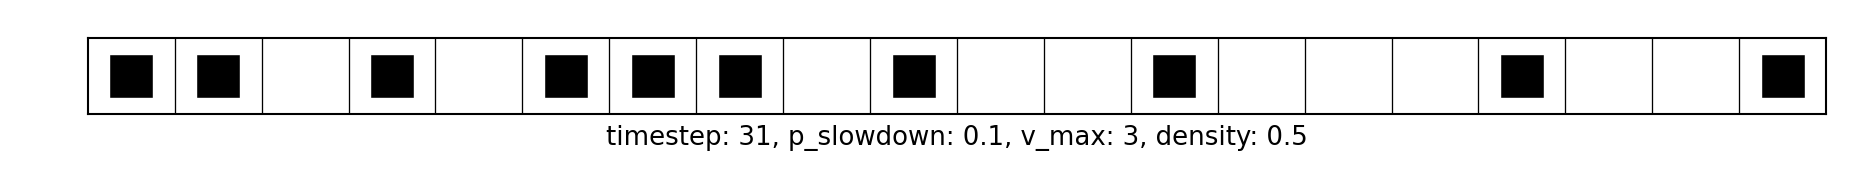

In [19]:
%matplotlib notebook 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random

# randomalize 
numofcell = 20     # length of road (circle)
numofcar = 10        # number of cars 
max_time = 100     # timestep 
max_speed = 3      # v_max 
p_slowdown = 0.1   # p_slowdown 
pause_time = 0.1   # refresh time  
cell_size = 15     # size of cell (how big it is)

# randomlize 
link = [None] * numofcell
num = 0
while num != numofcar:
    sj = random.randint(0, numofcell - 1)
    if link[sj] is None:
        link[sj] = random.randint(0, max_speed)
        num += 1

# update the function 
def update(frame):
    global link
    for cell in range(numofcell):
        if link[cell] is not None:
            # acceleration 
            link[cell] = min(link[cell] + 1, max_speed)
            # braking 
            link[cell] = min(link[cell], get_empty_front(link, numofcell, cell))
            # slow down 
            if random.random() <= p_slowdown:
                link[cell] = max(link[cell] - 1, 0)
    # update the place 
    nlink = [None] * numofcell
    for cell in range(numofcell):
        if link[cell] is not None:
            new_index = cell + link[cell]
            if new_index >= numofcell:
                new_index -= numofcell
            nlink[new_index] = link[cell]
    link = nlink

    x1 = [i for i in range(len(link)) if link[i] is not None]
    ax.clear()
    Plot_Space()
    ax.plot(x1, [0] * len(x1), 'sk', markersize=cell_size)
    #ax.set_xlabel('timestep: ' + str(frame))
    ax.set_xlabel(f'timestep: {frame}, p_slowdown: {p_slowdown}, v_max: {max_speed}, density: {numofcar/numofcell}')


fig, ax = plt.subplots(figsize=(10, 1))
ani = animation.FuncAnimation(fig, update, frames=max_time, repeat=True)
plt.tight_layout()
plt.show()
